In [1]:
# try lstm model
# 尝试 1/10的数据

In [19]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from torch.autograd import Variable
import random 
import os
import torch

In [3]:
device = 'cpu'
INPUT_DIR_PATH = 'C:/ZhangLI/Codes/DataSet/m5-forecasting-accuracy/'

# INPUT_DIR_PATH = 'E:/Dataset/m5-forecasting-accuracy/'

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
def read_data():
    sell_prices_df = pd.read_csv(INPUT_DIR_PATH + 'sell_prices.csv')
    sell_prices_df = reduce_mem_usage(sell_prices_df)
    print('Sell prices has {} rows and {} columns'.format(sell_prices_df.shape[0], sell_prices_df.shape[1]))

    calendar_df = pd.read_csv(INPUT_DIR_PATH + 'calendar.csv')
    calendar_df = reduce_mem_usage(calendar_df)
    print('Calendar has {} rows and {} columns'.format(calendar_df.shape[0], calendar_df.shape[1]))

    sales_train_validation_df = pd.read_csv(INPUT_DIR_PATH + 'sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation_df.shape[0], sales_train_validation_df.shape[1]))

    submission_df = pd.read_csv(INPUT_DIR_PATH + 'sample_submission.csv')
    return sell_prices_df, calendar_df, sales_train_validation_df, submission_df
_,  calendar_df, sales_train_validation_df, _ = read_data()

Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Sales train validation has 30490 rows and 1919 columns


In [5]:
date_index = calendar_df['date']  # 所有的日期 1969  2011-01-29 - 2016-06-19 
dates = date_index[0:1913]  # 2011-01-29 - 2016-04-24
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [6]:
# select one time series as an example
sales_train_validation_df['item_store_id'] = \
sales_train_validation_df.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
DF_Sales = sales_train_validation_df.loc[:,'d_1':'d_1913'].T
DF_Sales.columns = sales_train_validation_df['item_store_id'].values

In [7]:
#Set Dates as index 
DF_Sales = pd.DataFrame(DF_Sales).set_index([dates_list])
DF_Sales.index = pd.to_datetime(DF_Sales.index)
DF_Sales.head()  # 5 * 30490 

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,...,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
2011-01-29,0,0,0,0,0,...,0,0,0,0,0
2011-01-30,0,0,0,0,0,...,0,0,6,0,0
2011-01-31,0,0,0,0,0,...,2,0,0,0,0
2011-02-01,0,0,0,0,0,...,2,0,2,0,0
2011-02-02,0,0,0,0,0,...,0,0,2,0,0


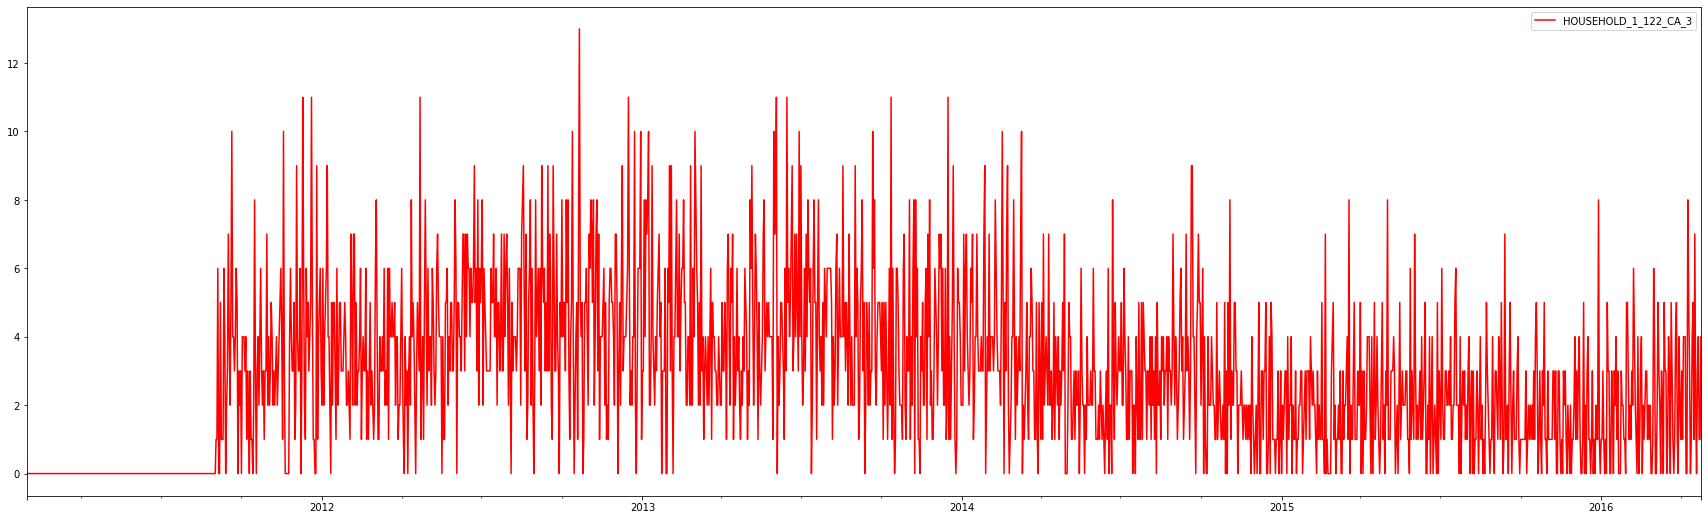

In [8]:
index = 6780
y = pd.DataFrame(DF_Sales.iloc[:,index])
y = pd.DataFrame(y).set_index([dates_list])
TS_selected = y 
y.index = pd.to_datetime(y.index)
ax = y.plot(figsize=(30, 9),color='red')

In [9]:
# normalization. We keep distribution of the data, but we change its scales.
from sklearn.preprocessing import MinMaxScaler
data = np.array(y)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(data.reshape(-1, 1))

In [10]:

SEED = 1345
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(SEED)

In [15]:
def sliding_windows(data, seq_length):
    x = []
    y = []

#     print(len(data))
#     print(seq_length)
#     print(len(data)-seq_length-1)
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

seq_length = 28
x, y = sliding_windows(train_data_normalized, seq_length)
print(x.shape)
print(y.shape)

1913
28
1884
(1884, 28, 1)
(1884, 1)


In [28]:
# 后面还是转换为 回归问题

# split data set for the train set and test set
train_size = int(len(y) * 0.67)  # 1262
test_size = len(y) - train_size  # 622

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))
testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

train shape is: torch.Size([1262, 28, 1])
train label shape is: torch.Size([1262, 1])
test shape is: torch.Size([622, 28, 1])
test label shape is: torch.Size([622, 1])


In [41]:
import torch.nn as nn
from fastprogress import master_bar, progress_bar

In [60]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        print(self.lstm)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        print(self.fc)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        print(f'h_0 shape: {h_0.shape}')
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        print(f'c_0 shape: {c_0.shape}')
        
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        print(f'ula shape {ula.shape}')
        print(f'h_out shape {h_out.shape}')
        
        h_out = h_out.view(-1, self.hidden_size)
        print(f'transform h_out is {h_out.shape}')
        
        out = self.fc(h_out)
        print(f'last2 out shape is {out.shape}')
        out = self.dropout(out)
        print(f'last2 out shape is {out.shape}')
    
        return out

# create a nn class (just-for-fun choice :-) 
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [61]:
#####  Parameters  ######################
num_epochs = 10  # 这里是什么
learning_rate = 1e-3  
input_size = 1
hidden_size = 64
num_layers = 1
num_classes = 1

#####Init the Model #######################
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

##### Set Criterion Optimzer and scheduler ####################
criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)

for epoch in progress_bar(range(num_epochs)): 
    print(f'epoch is {epoch}')
    lstm.train()
    print('train end')
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    optimizer.step()
    
    #Evaluate on test     
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

LSTM(1, 64, batch_first=True, dropout=0.25)
Linear(in_features=64, out_features=1, bias=True)


epoch is 0
train end
h_0 shape: torch.Size([1, 1262, 64])
c_0 shape: torch.Size([1, 1262, 64])
ula shape torch.Size([1262, 28, 64])
h_out shape torch.Size([1, 1262, 64])
transform h_out is torch.Size([1262, 64])
last2 out shape is torch.Size([1262, 1])
last2 out shape is torch.Size([1262, 1])
h_0 shape: torch.Size([1, 622, 64])
c_0 shape: torch.Size([1, 622, 64])
ula shape torch.Size([622, 28, 64])
h_out shape torch.Size([1, 622, 64])
transform h_out is torch.Size([622, 64])
last2 out shape is torch.Size([622, 1])
last2 out shape is torch.Size([622, 1])
Epoch: 0, loss: 0.48290 valid loss:  0.61395 
epoch is 1
train end
h_0 shape: torch.Size([1, 1262, 64])
c_0 shape: torch.Size([1, 1262, 64])
ula shape torch.Size([1262, 28, 64])
h_out shape torch.Size([1, 1262, 64])
transform h_out is torch.Size([1262, 64])
last2 out shape is torch.Size([1262, 1])
last2 out shape is torch.Size([1262, 1])
h_0 shape: torch.Size([1, 622, 64])
c_0 shape: torch.Size([1, 622, 64])
ula shape torch.Size([622, 2

In [81]:
# 1. X的特征数据为1
input_size = 1 # feature size of X
# 2. 隐藏层为64
hidden_size = 64

# 输出格式 X.shape 为 [28,1]
X_input = trainX  # [1262, 28, 1] (L, H_{in})  (L, N, H_{in})  True:(batch_size, seq_len, input_size)
h_0 = Variable(torch.zeros(1, X_input.size(0), 64)).shape  # [1, 1262, 64]  (num_layer, batch_size, hidden_size)
c_0 = Variable(torch.zeros(1, X_input.size(0), 64)).shape  # [1, 1262, 64]  (num_layer, batch_size, hidden_size)


lstm.lstm.weight_ih_l0.shape # [256, 1]  (W_ii|W_if|W_ig|W_io) (4*hidden_size, input_size) [64, 1]
lstm.lstm.weight_hh_l0.shape # [256, 64]  (W_hi|W_hf|W_hg|W_ho) (4*hidden_size, hidden_size). [64, 64]
lstm.lstm.bias_ih_l0.shape  # ([256])  b_ii|b_if|b_ig|b_io [64]
lstm.lstm.bias_hh_l0.shape  # [256]

# 计算输入门的参数
#----------------------------------------------
# W_ii    x_t + b_ii +  w_hi  h_t + b_hi (矩阵乘法)
# [64,1]  [1] + [64] + [64,64] [64,1] + [64] = [64, 1]
# 计算遗忘门的参数
# --------------------------------------------------
# f_t * c_t + i_t * g_t (点积)
# [64,1] [64,1] + [64,1] [64,1] = [64,1]
# -------------------------------------------------
# 输出层的参数
# out shape torch.Size([1262, 28, 64])  (batch_size, seq_len, D∗hidden_size)
# h_n shape torch.Size([1, 1262, 64])  (D∗num_layers, batch_size, hidden_size)
# transform h_out is torch.Size([1262, 64])
# 全连接层的参数
# fc [batch_size,hidden_size] [hidden_size, number_label]
#  [1262, 64] [64, 1]

torch.Size([256])

h_0 shape: torch.Size([1, 1884, 64])
c_0 shape: torch.Size([1, 1884, 64])
ula shape torch.Size([1884, 28, 64])
h_out shape torch.Size([1, 1884, 64])
transform h_out is torch.Size([1884, 64])
last2 out shape is torch.Size([1884, 1])
last2 out shape is torch.Size([1884, 1])


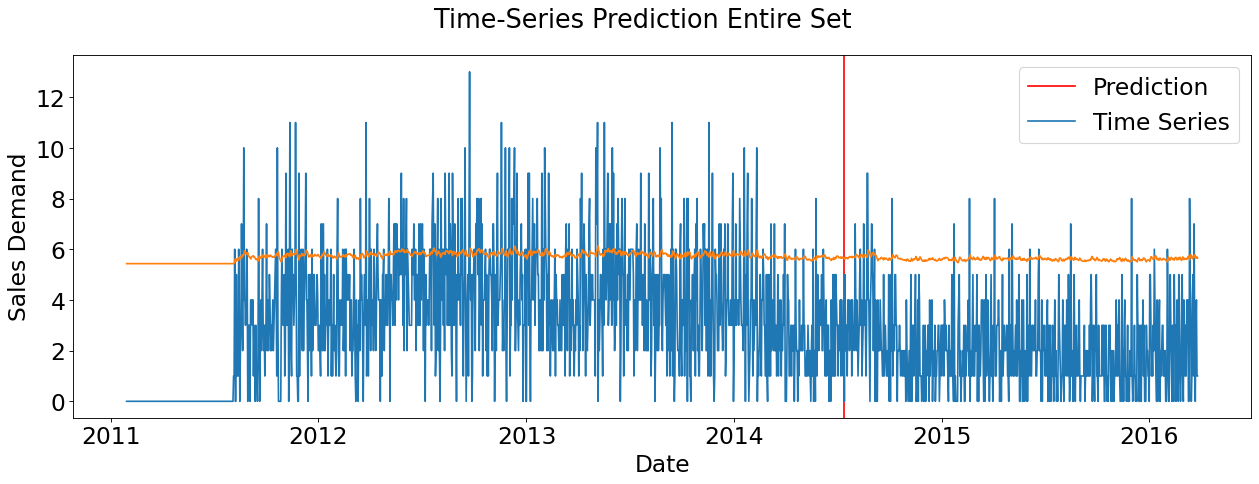

In [98]:
lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

from matplotlib.pyplot import figure
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [ ]:
# https://www.kaggle.com/code/omershect/learning-pytorch-lstm-deep-learning-with-m5-data